# AlphaTims + pyopenms_viz Tutorial

This tutorial will cover using AlphaTims for targeted extraction for DIA Bruker data, and visualizing the targeted extracted data using pyopenms_viz.

1. [Prerequisites](#first-bullet)
2. [Download DIA example data](#second-bullet)
3. [Load Required Libraries](#third-bullet)
4. [Load Data](#foruth-bullet)
5. [Extracting Data for peptide](#fifth-bullet)
6. [Spectrum Plotting](#sixth-bullet)
7. [Chromatogram Plotting ](#seventh-bullet)
8. [Mobilogram Plotting ](#eigth-bullet)
9. [2D Peak Map Plotting](#ninth-bullet)

## Prerequisites <a class="anchor" id="first-bullet"></a>

Ensure you have the required AlphaTims module and pyopenms_viz module installed

In [1]:
# !pip install "alphatims[plotting]"

## Download DIA example data <a class="anchor" id="second-bullet"></a>

You can download an example data file from [AlphaTim's github DIA example](https://github.com/MannLabs/alphatims/releases/download/0.1.210317/20201207_tims03_Evo03_PS_SA_HeLa_200ng_EvoSep_prot_high_speed_21min_8cm_S1-C8_1_22474.d.zip). You can run the cell below to download and unzip the data to the current working directory of this notebook. Or manually download by clicking the previous example hyperlink.

In [2]:
run_download=False
if run_download:
    import requests
    import zipfile
    import io
    import os
    
    # URL of the file to download
    url = "https://github.com/MannLabs/alphatims/releases/download/0.1.210317/20201207_tims03_Evo03_PS_SA_HeLa_200ng_EvoSep_prot_high_speed_21min_8cm_S1-C8_1_22474.d.zip"
    
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Create a ZipFile object from the content of the response
        z = zipfile.ZipFile(io.BytesIO(response.content))
        
        # Extract all contents to the current directory
        z.extractall()
        print("File downloaded and extracted successfully.")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")


## Load Required Libraries <a class="anchor" id="third-bullet"></a>

We need `alphatims.bruker` module to access the raw data from the DIA bruker file, `output_notebook` from `bokeh.io` to allow for inline plotting for bokeh figures and we need a few config classes to customize the pyopenms_viz plots

In [3]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
import alphatims.bruker
from bokeh.io import output_notebook
import sys 
sys.path.append('../')
import pyopenms_viz

output_notebook()

Loading BokehJS ...

## Load Data  <a class="anchor" id="fourth-bullet"></a>

Lets load the DIA bruker data into memory

In [4]:
bruker_dia_d_folder_name = "./20201207_tims03_Evo03_PS_SA_HeLa_200ng_EvoSep_prot_high_speed_21min_8cm_S1-C8_1_22474.d"
dia_data = alphatims.bruker.TimsTOF(bruker_dia_d_folder_name)

/home/singjc/anaconda3/envs/py310/lib/python3.10/site-packages/alphatims/bruker.py:237: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frames.Id[0] = 0
/home/singjc/anaconda3/envs/py310/lib/python3.10/site-packages/alphatims/bruker.py:238: Fu

## Extracting Data for peptide  <a class="anchor" id="fifth-bullet"></a>

Let's modify the `inspect_peptide` method from [alphatims/nbs
/tutorial.ipynb](https://github.com/MannLabs/alphatims/blob/master/nbs/tutorial.ipynb) to return a dataframe with extracted data for the target precursor and fragemnt ions.

In [5]:
def inspect_peptide(
    dia_data,
    peptide,
    ppm=50,
    rt_tolerance=30, #seconds
    mobility_tolerance=0.05, #1/k0
):
    precursor_mz = peptide["mz"]
    precursor_mobility = peptide["mobility"]
    precursor_rt = peptide["rt"]
    fragment_mzs = peptide["fragment_mzs"]
    rt_slice = slice(
        precursor_rt - rt_tolerance,
        precursor_rt + rt_tolerance
    )
    im_slice = slice(
        precursor_mobility - mobility_tolerance,
        precursor_mobility + mobility_tolerance
    )
    precursor_mz_slice = slice(
        precursor_mz / (1 + ppm / 10**6),
        precursor_mz * (1 + ppm / 10**6)
    )
    precursor_indices = dia_data[
        rt_slice,
        im_slice,
        0, #index 0 means that the quadrupole is not used
        precursor_mz_slice,
        "raw"
    ]
    prec_df = dia_data.as_dataframe(precursor_indices)
    prec_df['Annotation'] = 'prec'
    # print(f"Info: Shape of prec - {prec_df.shape}")

    all_dfs = []
    all_dfs.append(prec_df)
    for fragment_name, mz in fragment_mzs.items():
        fragment_mz_slice = slice(
            mz / (1 + ppm / 10**6),
            mz * (1 + ppm / 10**6)
        )
        fragment_indices = dia_data[
            rt_slice,
            im_slice,
            precursor_mz_slice,
            fragment_mz_slice,
            "raw"
        ]
        frag_df = dia_data.as_dataframe(fragment_indices)
        frag_df['Annotation'] = fragment_name
        # print(f"Info: Shape of {fragment_name} - {frag_df.shape}")
        all_dfs.append(frag_df)

    all_df = pd.concat(all_dfs, axis=0)
    all_df['ms_level'] = all_df['Annotation'].apply(lambda x: 1 if x == 'prec' else 2)

    return all_df


Let's create a peptide dictionary with target coordinates for our target peptide

In [6]:
peptide = {
    "sequence": "YNDTFWK",
    "mz": 487.22439,
    "mobility": 0.81,
    "rt": 9.011 * 60, #seconds
    "charge": 2,
    "fragment_mzs": {
        "y7": 973.44145,
        "y6": 810.37812,
        "y5": 696.33520,
        "y4": 581.30825,
        "y3": 480.26057,
        "y2": 333.19216,
        "y1": 147.11285,
        "b1": 164.07065,
        "b2": 278.11358,
        "b3": 393.14052,
        "b4": 494.18820,
        "b5": 641.25661,
        "b6": 827.33592,
        "b7": 955.43089,
    }    
}


In [7]:
dia_df = inspect_peptide(dia_data, peptide, 50, 70, 0.1)
dia_df

,raw_indices,frame_indices,scan_indices,precursor_indices,push_indices,tof_indices,rt_values,rt_values_min,mobility_values,quad_low_mz_values,quad_high_mz_values,mz_values,intensity_values,corrected_intensity_values,Annotation,ms_level
0,146798839,4438,694,0,4119158,152514,470.926503,7.848775,0.865903,-1.0,-1.0,487.228624,54,54,prec,1
1,146799536,4438,695,0,4119159,152515,470.926503,7.848775,0.864769,-1.0,-1.0,487.232119,68,68,prec,1
2,146802782,4438,700,0,4119164,152516,470.926503,7.848775,0.859099,-1.0,-1.0,487.235614,61,61,prec,1
3,146809110,4438,711,0,4119175,152519,470.926503,7.848775,0.846621,-1.0,-1.0,487.246098,144,144,prec,1
4,146809639,4438,712,0,4119176,152519,470.926503,7.848775,0.845486,-1.0,-1.0,487.246098,94,94,prec,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,255542671,5684,671,4,5275423,264156,602.997099,10.049952,0.891960,475.0,500.0,955.470987,145,145,b7,2
152,257300501,5702,746,4,5292202,264157,604.905047,10.081751,0.806864,475.0,500.0,955.475880,158,158,b7,2
153,260842198,5738,715,4,5325579,264145,608.719248,10.145321,0.842081,475.0,500.0,955.417157,79,79,b7,2
154,261754335,5747,749,4,5333965,264155,609.673048,10.161217,0.803453,475.0,500.0,955.466093,93,93,b7,2


### Spectrum Plotting  <a class="anchor" id="sixth-bullet"></a>

Let's take a look at the extracted ion spectrum data, and separate the traces by **Annotation** using a static Matplotlib plotting backend. \
**Note**: we specify the *backend* argument for pandas `plot` method as 'pomsvim' for the matplotlib plotting library.

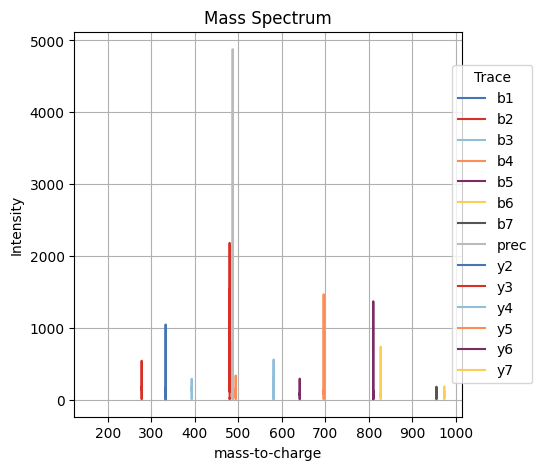

In [8]:
dia_df.plot(x="mz_values", 
             y="intensity_values", 
             kind="spectrum", 
             by="Annotation", 
             backend="pomsvim")

We can change some of the aesthetics of the plots. Check the `help` documentation for the plotting backend.

In [9]:
help(dia_df.plot(x="mz_values", y="intensity_values", backend="pomsvim"))

Help on MATPLOTLIBLinePlot in module pyopenms_viz.plotting._matplotlib.core object:

class MATPLOTLIBLinePlot(MATPLOTLIBPlot, pyopenms_viz.plotting._core.LinePlot)
 |  MATPLOTLIBLinePlot(data, x: 'str | None' = None, y: 'str | None' = None, z: 'str | None' = None, kind=None, by: 'str | None' = None, relative_intensity: 'bool' = False, subplots: 'bool | None' = None, sharex: 'bool | None' = None, sharey: 'bool | None' = None, height: 'int | None' = None, width: 'int | None' = None, grid: 'bool | None' = None, toolbar_location: 'str | None' = None, fig: "'figure' | None" = None, title: 'str | None' = None, xlabel: 'str | None' = None, ylabel: 'str | None' = None, x_axis_location: 'str | None' = None, y_axis_location: 'str | None' = None, line_type: 'str | None' = None, line_width: 'float | None' = None, min_border: 'int | None' = None, show_plot: 'bool | None' = None, legend: 'LegendConfig | Dict | None' = None, feature_config: 'FeatureConfig | Dict | None' = None, _config: '_BasePlotter

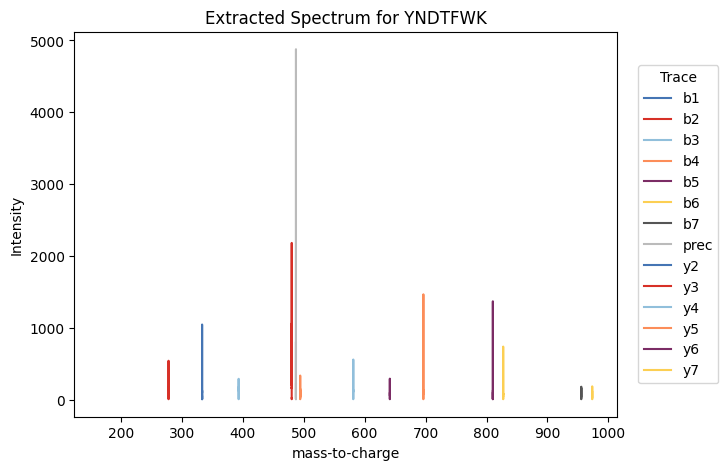

In [10]:
dia_df.plot(x="mz_values", 
            y="intensity_values", 
            kind="spectrum", 
            by="Annotation", 
            title = f"Extracted Spectrum for {peptide['sequence']}",
            height=500, width=700,
            grid=False, # Remove the grid
            legend = {'title':'Trace', 'bbox_to_anchor':(1.2,0.5)},
            backend="pomsvim")

pyopenms_viz supports three different backends, Matplotlib, Bokeh and Plotly for static and interactive plots. Let's look at an example of a Bokeh spectrum plot. We can change the backend arg to **pomsvib**.

Possible backends are:
* matplotlib = "pomsvim"
* bokeh = "pomsvib"
* plotly = "pomsvip"

In [11]:
dia_df.plot(x="mz_values", 
            y="intensity_values", 
            kind="spectrum", 
            by="Annotation", 
            title = f"Extracted Spectrum for {peptide['sequence']}",
            height=500, width=700,
            grid=False, # Remove the grid
            legend = {'title':'Trace', 'bbox_to_anchor':(1.2,0.5)},
            backend="pomsvib")

### Chromatogram Plotting  <a class="anchor" id="seventh-bullet"></a>

Let's plot an extracted ion chromatgram, but before we do that, let's preprocess the data and integrate the intensity values across ion mobility dimension to get an integrated extracted ion chromatogram per precursor and fragment ions.

In [12]:
group_cols=['ms_level', 'Annotation', 'rt_values']
integrate_col = 'intensity_values'
dia_xic_df = dia_df.apply(
                lambda x: x.fillna(0) if x.dtype.kind in "biufc" else x.fillna(".")
            ) \
            .groupby(group_cols)[integrate_col] \
            .sum() \
            .reset_index()

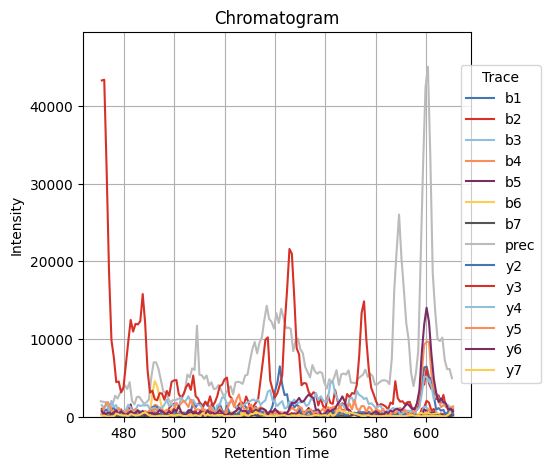

In [13]:
dia_xic_df.plot(x='rt_values',
                  y='intensity_values',
                  kind='chromatogram',
                  by='Annotation',
                  backend='pomsvim'
                 )

Similar to changing aesthetics for the spectrum plot, we can change some of the aesthetics of the chromatogram plots as well.

In [ ]:
dia_xic_df.plot(x="rt_values", 
                y="intensity_values", 
                kind='chromatogram',
                by='Annotation', 
                title = f"Extracted Chromatogram for {peptide['sequence']}",
                height=500, width=700,
                grid=False, # Remove the grid
                legend = {'title':'Trace'},
                backend="pomsvim")

Let's take a look at a bokeh version of the chromatogram plot

In [ ]:
p = dia_xic_df.plot(x="rt_values", 
            y="intensity_values", 
            kind='chromatogram',
            by='Annotation', 
            title = f"Extracted Chromatogram for {peptide['sequence']}",
            height=500, width=700,
            grid=False, # Remove the grid
            legend = {'title':'Trace'},
            backend="pomsvib")

The nice thing about interactive bokeh plots, is it allows for adding editable vertical peak boundaries. You can click the box edit tool which allows you to add peak boundaries to the figure.

- To draw boxes - hold the left-click mouse button for a few seconds, then you can release to start drawing. To stop drawing, hold the left-click and move the mouse away.
- To move boxes - double click on a box and move it around and then release.
- To delete boxes - click on a box, and press backspace to remove. 
- Unclick the box-edit tool to deactivate the tool

We can then get the boundaries drawn by using the `get_manual_bounding_box_coords` method.

In [ ]:
p.get_manual_bounding_box_coords()

### Mobilogram Plotting  <a class="anchor" id="eigth-bullet"></a>

Let's plot an extracted ion mobilogram, but before we do that, let's preprocess the data and integrate the intensity values across retention time dimension to get an integrated extracted ion mobilogram per precursor and fragment ions.

In [ ]:
group_cols=['ms_level', 'Annotation', 'mobility_values']
integrate_col = 'intensity_values'
dia_xim_df = dia_df.apply(
                lambda x: x.fillna(0) if x.dtype.kind in "biufc" else x.fillna(".")
            ) \
            .groupby(group_cols)[integrate_col] \
            .sum() \
            .reset_index()

In [ ]:
dia_xim_df.plot(x='mobility_values',
                  y='intensity_values',
                  kind='mobilogram',
                  by='Annotation',
                  backend='pomsvim'
                 )

### 2D Peak Map Plotting  <a class="anchor" id="ninth-bullet"></a>

Let's see what the retention time and ion mobility peak map looks like for the precursor ion.

In [ ]:
p = dia_df[dia_df.ms_level==1].plot(x="rt_values", 
                                    y="mobility_values", 
                                    z="intensity_values", 
                                    kind="feature_heatmap", 
                                    by="ms_level", 
                                    add_marginals=False, 
                                    xlabel="Retention Time [sec]", 
                                    ylabel="Ion Mobility", 
                                    height=600, width=700,
                                    grid=False, show_plot=True,
                                    legend = {'title':'MS Level', 'loc':'right', 'onClick':'hide'},
                                    backend="pomsvim")


Let's look at the full extracted dataset, and separate traces by **ms_level** and add marginal plots for the x-axis and y-axis using the bokeh backend

In [ ]:
p = dia_df.plot(x="rt_values", 
                y="mobility_values", 
                z="intensity_values", 
                kind="feature_heatmap", 
                by="ms_level", 
                add_marginals=True, 
                ylabel="Ion Mobility", 
                zlabel="Intensity",
                width=500,
                height=500,
                grid=False,
                legend={'title':'MS Level', 'loc':'below', 'orientation':'horizontal'},
                feature_config={'legend':{'loc':'below'}},
                backend="pomsvib")